<h1>Gender in <i>The Simpsons</i></h1>

Justin Lim (PI, Digital Humanities Student)

Instructor: Adam Anderson, Ph.D

Course: Digital Humanities 100 | Summer 2021

<img src="images/couch_gags.gif">
<center> [gif credit: <a href= "https://imgur.com/gallery/TsL9o">imgur</a> ] </center>

## Project Description:  ##

As one of America’s most popular hit television shows-- aptly accredited with being the longest running show on air, today-- The Simpson’s responds to popular culture as much as it is a part of it. It’s thirty-two seasons have not only made references to global politics, but also celebrity gossip, natural disasters, and even other popular television shows. For more context on the show, <a href='https://en.wikipedia.org/wiki/The_Simpsons'>check out this Wikipedia article! </a> 

Based on its consistent place in popular culture, the stories and representations presented in The Simpson’s would be a great metric in measuring how progressive ideals are being normalized in the grand scheme of national culture. <b><u> Taking a specifically feminist critical viewpoint, this project explores representations of gender in the Fox television show, *The Simpsons*-- specifically analyzing trends in gender representation and comparing dialogue between groups. </u></b> As an important note of discretion, this project is confined to a binarical lens of gender due to the limitations of the dataset, yet does not subscribe to this viewpoint. 

## Table of Contents ##

1. Python Libraries

2. Exploratory Data Analysis

3. Text Data Preprocessing

4. Gender Distribution Over Time

5. Comparing Dialogue
    
    1. Word Cloud
    
    1. Unigram Analysis
    
    1. Bigram Analysis
    
6. Topic Model

7. Conclusions

## Python Libraries ##

Here, I import the libraries I need for my analysis.

The first group of libraries help to clean, rearrange, and manage data. The second group of imports include the tools needed to create this notebook's visualizations; this includes: line plots, word clouds, histograms, topic models, etc. The second group of imports helps with textual analysis. These tools aid in text preprocessing, which prepares text data for analysis, as well as creating textual analysis models. Next, LatentDirichletAllocation is an unsupervised machine learning algorithm which helps us with finding topics in our data for our topic model. Furthermore, the pickle library is used to store models that whose code has long run times. I do this to prevent the long runtime of creating and fitting our models; however, the code is still provided below-- just commented out-- to follow along.

In [55]:
# General imports
import numpy as np 
import os
import pandas as pd
from collections import Counter # Count most common words
import re # regular expressions

# Visualization imports
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pyLDAvis.sklearn # visualize our topic models!
from wordcloud import WordCloud # Visualize word clouds 

# NLP imports
import nltk # natural language toolkit
from nltk.corpus import stopwords
from nltk.corpus import movie_reviews # another dataset 
import string # for punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer # Tools to create our DTMs

# Algorithms (unsupervised)
from sklearn.decomposition import LatentDirichletAllocation
# CV (multiple train/test splitting)
from sklearn.model_selection import cross_val_score, train_test_split
# (supervised)
from sklearn.linear_model import LogisticRegression

# To save large models
import pickle

# Remove warnings to make notebook prettier
import warnings
warnings.filterwarnings("ignore")

## Exploratory Data Analysis ##

For this project, I use Prashant Banerjee's "The Simpson's Dataset" (2020) posted on Kaggle. This dataset was originally web-scraped by Tod Schneider from the following websites: “Simpson’s World”, a The Simpson’s wikipedia; Wikipedia; and IMDb. The dataset is split into four datasets: the character dataset, the episode dataset, the locations dataset, and the script lines dataset. Because the character dataset and the script dataset had information about characters, speaking lines, and gender, I focused my analysis on these two datasets.

In [3]:
# Import Dataframes
s_script = pd.read_csv('simpsons_data/simpsons_script_lines.csv')
s_char = pd.read_csv('simpsons_data/simpsons_characters.csv')

Each dataset contains the following information:

In [4]:
list(s_script.columns)

['id',
 'episode_id',
 'number',
 'raw_text',
 'timestamp_in_ms',
 'speaking_line',
 'character_id',
 'location_id',
 'raw_character_text',
 'raw_location_text',
 'spoken_words',
 'normalized_text',
 'word_count']

In [5]:
list(s_char.columns)

['id', 'name', 'normalized_name', 'gender']

For simplicity's sake, I merged these two tables into one and dropped the irrelevant columns.

In [6]:
# Create a dataframe that merges both script and the character information.
# Now, we have the gender of each character, as well as their names, the timestamp
# of their speaking lines, and their character id.

script = s_script[['episode_id', 
                   'timestamp_in_ms',
                   'raw_location_text',
                   'raw_character_text', 
                   'spoken_words', 
                   'word_count']].rename(columns = {'raw_character_text': 'name', 
                                                    'spoken_words': 'line'})
chars = s_char.dropna().rename(columns = {'id': 'char_id'})
script_table = script.merge(chars)
script_table = script_table[['episode_id', 'normalized_name', 'char_id', 'gender' , 'line', 'timestamp_in_ms', 'raw_location_text']]
script_table.head()

,episode_id,normalized_name,char_id,gender,line,timestamp_in_ms,raw_location_text
0,32,miss hoover,464,f,"No, actually, it was a little of both. Sometim...",848000,Springfield Elementary School
1,32,miss hoover,464,f,I don't know. Although I'd sure like to talk t...,856000,Springfield Elementary School
2,49,miss hoover,464,f,"Thank you, Ralph. Very graphic. Lisa Simpson? ...",784000,Springfield Elementary School
3,49,miss hoover,464,f,Dear God!,803000,Springfield Elementary School
4,51,miss hoover,464,f,I question the educational value of this assem...,226000,Springfield Elementary School


# Data Preprocessing #

Next, we will be preprocessing our data!! We do this to improve the correctness of our models by standardizing the text data. To do this, we first split our data into our two desired groups. In this way, we can perform separate analyses and accurately perform comparisons. 
Then, our standardization steps include the following:
1. Removing punctions
2. Standardizing letter case (in this case, lowercase)
3. Removing numbers

In [7]:
# Separate table into gender groups
w_table = script_table[script_table['gender'] == 'f']
m_table = script_table[script_table['gender'] == 'm']

text_w = w_table[['normalized_name', 'line']].reset_index().rename(index = str)
text_m = m_table[['normalized_name', 'line']].reset_index().rename(index = str)

# Remove punctuation
text_w['text_processed'] = text_w['line'].map(lambda x: re.sub('[,\.!?\']', '', str(x)))
text_m['text_processed'] = text_m['line'].map(lambda x: re.sub('[,\.!?\']', '', str(x)))

# Convert to lowercase
text_w['text_processed'] = text_w['text_processed'].str.lower()
text_m['text_processed'] = text_m['text_processed'].str.lower()

# Remove digits
text_w['text_processed'] = text_w['text_processed'].str.replace('\d+', '')
text_m['text_processed'] = text_m['text_processed'].str.replace('\d+', '')

In [8]:
# Drop NA values in the text_processed column, they are unusable in analysis.
text_w = text_w.dropna(subset= ['text_processed'])
text_m = text_m.dropna(subset= ['text_processed'])

For later analyses, we will also convert our processed texts into singular, long strings.

In [9]:
w_long = ','.join(text_w["text_processed"].values)
m_long = ','.join(text_m["text_processed"].values)

Let's print the beginning of one long string to see what they look like!

In [10]:
w_long[:1000]

'no actually it was a little of both sometimes when a disease is in all the magazines and all the news shows its only natural that you think you have it,i dont know although id sure like to talk to him he didnt touch my lesson plan what did he teach you,thank you ralph very graphic lisa simpson would you like to read your essay,dear god,i question the educational value of this assembly,edna happy hour in the teachers lounge,wow "a million poets working for a million years" youre so lucky when are you gonna meet him,uh huh,were going to take a test,its called the career aptitude normalizing test or "cant",question sixty: i prefer the smell of a) gasoline; b) french fries; or c) bank customers",since we have fifteen minutes until recess please put down your pencils and stare at the front of the room,now take some paste and spread it on the construction paper ralph are you eating your paste,good now sprinkle your sparkles on your paste lisa youre not sprinkling your sparkles,nan,now lets 

There seems to still be some punctuation left over! Looking closer, we see that this is because the punctuation marks do not have spaces after them-- they are followed directly by the beginning of the word. From looking closer at our data, we can recognize which common punctuation marks got left behind and replace them, like below:

In [11]:
# Record the common punctuation marks left behind
punc = [',', '"', ')', ';', ':']

# Parse through string and remove them
for mark in punc:
    w_long = w_long.replace(mark, ' ')
w_long = w_long.replace('  ', ' ')

In [12]:
w_long[:1000]

'no actually it was a little of both sometimes when a disease is in all the magazines and all the news shows its only natural that you think you have it i dont know although id sure like to talk to him he didnt touch my lesson plan what did he teach you thank you ralph very graphic lisa simpson would you like to read your essay dear god i question the educational value of this assembly edna happy hour in the teachers lounge wow a million poets working for a million years youre so lucky when are you gonna meet him uh huh were going to take a test its called the career aptitude normalizing test or cant question sixty i prefer the smell of a gasoline b french fries or c bank customers since we have fifteen minutes until recess please put down your pencils and stare at the front of the room now take some paste and spread it on the construction paper ralph are you eating your paste good now sprinkle your sparkles on your paste lisa youre not sprinkling your sparkles nan now lets correct our

That looks much better! Now, we will repeat the process with our other string, and then we'll be ready for to do our anaylsis. 

In [13]:
for mark in punc:
    m_long = m_long.replace(mark, ' ')
m_long = m_long.replace('  ', ' ')

# Gender Distribution Over Time #

Our analysis first consists of comparing the amount of space women occupy in the show compared to men. To do this, script table will be manipulated used *pandas* methods to output the number of speaking lines for women and men per episode. From there, calculations are made to output the proportion of each per episode. Lastly, this frequency table is visualized using the *matplotlib* library to show trends over time. 

As a long time fan, I believe that there will be an increase in female speaking roles. *The Simpsons* is a show which has kept close to pop culture, and with discussions about increased gender diversity becoming more normalized, I believe show writers will take note of it. However, in being a popular show, I believe this change will be small, if not barely significant. 

Below is a test I created with a small subset of the data; I did this to avoid the long runtime of using the entire dataset:

In [14]:
## Testing Idea

# Keep only these columns
test_32 = script_table[['episode_id', 'gender', 'normalized_name']]

# Find all the values of episode 32
test_32 = test_32[test_32['episode_id'] == 32]

# Group values by the gender column, and count the 
# total size of each
test_counts = test_32.groupby('gender').count()
test_counts

,episode_id,normalized_name
gender,,
f,122,122
m,157,157


<img src='images/celebration.gif'>
<center>[gif credit: <a href= https://giphy.com/gifs/season-3-the-simpsons-3x11-xT5LMQ8rHYTDGFG07e>giphy</a>]</center>

It looks like our idea worked! Now to scale it onto the entire dataset.

In [15]:
## Create counts table
# 'gdt' stands for "Gender Distribution Table"
gdt = script_table[['episode_id', 'gender', 'normalized_name']].sort_values(['episode_id'])
counts_gdt = gdt.groupby(['episode_id', 'gender']).count()
counts_gdt.head()

normalized_name
episode_id gender                 
1          f                    89
           m                   230
2          f                    59
           m                   194
3          f                    45

In [18]:
# Intialize empty strings to store count data
w_dist = []
m_dist = []

# Set for loop to iterate through our count table, and place
# the correct count value into each distribution.
n = len(counts_gdt)
for i in range(n):
    if i % 2 == 0:
        w_dist.append(counts_gdt.iloc[i][0])
    else:
        m_dist.append(counts_gdt.iloc[i][0])

# Create a dataframe with count values, and calculate proportions       
gdt_table = pd.DataFrame({'womens_dist': w_dist, 'mens_dist': m_dist}).reset_index()
gdt_table['total'] = [a + b for a, b in zip(w_dist, m_dist)]
gdt_table['womens_dist'] = gdt_table['womens_dist']/ gdt_table['total']
gdt_table['mens_dist'] = gdt_table['mens_dist']/ gdt_table['total']
gdt_table.head()

,index,womens_dist,mens_dist,total
0,0,0.278997,0.721003,319
1,1,0.233202,0.766798,253
2,2,0.257143,0.742857,175
3,3,0.291045,0.708955,268
4,4,0.188755,0.811245,249


Our table looks good! However, to double check the distribution data, the two columns will be added. If done correctly, they should add up to '1.0' or 100%.

In [23]:
gdt_table['total'] = gdt_table['womens_dist'] + gdt_table['mens_dist']
gdt_table.head()

,index,womens_dist,mens_dist,total
0,0,0.278997,0.721003,1.0
1,1,0.233202,0.766798,1.0
2,2,0.257143,0.742857,1.0
3,3,0.291045,0.708955,1.0
4,4,0.188755,0.811245,1.0


Now, we can visualize the results!

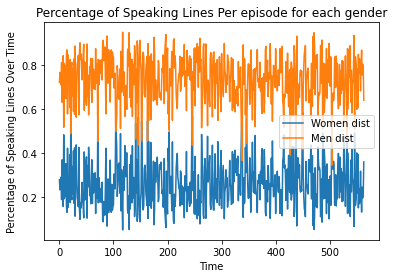

In [24]:
## Graph Distributions

# Set figure size
plt.figure(figsize= (6,4))

# Plot graph for women
plt.plot(gdt_table['womens_dist'], label= 'Women dist')

# Plot graph for men
plt.plot(gdt_table['mens_dist'], label= 'Men dist')

# Create axis labels
plt.ylabel('Percentage of Speaking Lines Over Time')
plt.xlabel('Time')

# Create graph title
plt.title('Percentage of Speaking Lines Per episode for each gender')

# Create legend for each line
plt.legend()
plt.show();

This graph is very overplotted; the overly numerous datapoints cloud any actual trends. To fix this, a function was constructed to average out a n-portions of the text at a time:

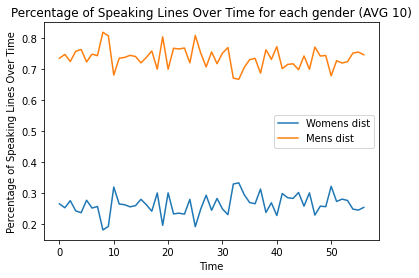

In [25]:
## Define average function

def create_avgs(tbl, n):
    # Initialize empty lists for each group
    w = []
    m = []

    # Parse through data, and average n-sized groups
    i = 0
    while i < len(tbl):
        if i + n > len(tbl):
            w.append(np.mean(tbl['womens_dist'][i:]))
            m.append(np.mean(tbl['mens_dist'][i:]))
        else:
            w.append(np.mean(tbl['womens_dist'][i:i+n]))
            m.append(np.mean(tbl['mens_dist'][i:i+n]))
        i += n
        
    return w, m

# Plot averaged values grouped per 10
w_avgs, m_avgs = create_avgs(gdt_table, 10)

plt.figure(figsize= (6,4))
plt.plot(w_avgs, label= 'Womens dist')
plt.plot(m_avgs, label= 'Mens dist')
plt.ylabel('Percentage of Speaking Lines Over Time')
plt.xlabel('Time')
plt.title('Percentage of Speaking Lines Over Time for each gender (AVG 10)')
plt.legend()
plt.show();

In [ ]:
# Plot averaged values grouped per 50
w_avgs, m_avgs = create_avgs(gdt_table, 50)

plt.figure(figsize= (6,4))
plt.plot(w_avgs, label= 'Womens dist')
plt.plot(m_avgs, label= 'Mens dist')
plt.ylabel('Percentage of Speaking Lines Over Time')
plt.xlabel('Time')
plt.title('Percentage of Speaking Lines Over Time for each gender (AVG 50)')
plt.legend()
plt.show();

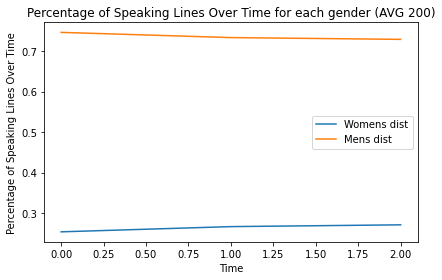

In [93]:
# Plot averaged values grouped per 20
w_avgs, m_avgs = create_avgs(gdt_table, 200)

plt.figure(figsize= (6,4))
plt.plot(w_avgs, label= 'Womens dist')
plt.plot(m_avgs, label= 'Mens dist')
plt.ylabel('Percentage of Speaking Lines Over Time')
plt.xlabel('Time')
plt.title('Percentage of Speaking Lines Over Time for each gender (AVG 200)')
plt.legend()
plt.show();

As we can see, there seems to be an increase in female speaking roles over time, but it is small and insignificant. 

# Comparing Dialogue #


Next, we will be comparing the content of the speaking lines for each gender group. To do so, we will first visualize word clouds of the most popular words per group, and examine any differences. Then, we will create an unigram and a bigram model to compare the most commonly used short phrases per group. 

To begin our analysis, we first create a Bag of Words (BOW) model. This model is helpful because it allows us to work with each word of the text as piece of data in the conglomerate; the sacrifice we pay is that the words are no longer in order. For more information on Bag of Words models, <a href='https://medium.com/greyatom/an-introduction-to-bag-of-words-in-nlp-ac967d43b428'>check out this medium article which talks more about it!</a>

### Create a Bag of Words model ###

First, we create an empty BOW model and fit it to our data. Fitting a model to our data aligns it to make predictions based on that data by finding patterns from it:

In [27]:
# Define empty BOW models
vec_w = CountVectorizer()
vec_m = CountVectorizer()

# Use the .fit method to tokenize the text and learn the vocabulary
vec_w.fit(text_w["text_processed"])
vec_m.fit(text_m["text_processed"])

CountVectorizer()

### Create Document Term Matrix (DTM) ###

Next, we create a DTM. A DTM gives us the frequencies for each term in the dataset

In [30]:
# Encode documents
vector_w = vec_w.transform(text_w["text_processed"])
vector_m = vec_m.transform(text_m["text_processed"])

Let's visualize our DTM to see what it looks like!

In [31]:
print(type(vector_w))
print(vector_w[:2])

<class 'scipy.sparse.csr.csr_matrix'>
  (0, 153)	1
  (0, 351)	2
  (0, 451)	1
  (0, 1638)	1
  (0, 4114)	1
  (0, 6660)	1
  (0, 7328)	1
  (0, 7619)	1
  (0, 7641)	2
  (0, 7652)	1
  (0, 8504)	1
  (0, 8764)	1
  (0, 9709)	1
  (0, 9812)	1
  (0, 9876)	1
  (0, 10076)	1
  (0, 10170)	1
  (0, 13175)	1
  (0, 13640)	1
  (0, 14792)	1
  (0, 14799)	2
  (0, 14849)	1
  (0, 16067)	1
  (0, 16229)	1
  (0, 16646)	2
  (1, 393)	1
  (1, 3994)	1
  (1, 3997)	1
  (1, 4275)	1
  (1, 6676)	2
  (1, 6847)	1
  (1, 7222)	1
  (1, 8053)	1
  (1, 8362)	1
  (1, 8435)	1
  (1, 9628)	1
  (1, 10968)	1
  (1, 14383)	1
  (1, 14568)	1
  (1, 14657)	1
  (1, 15002)	2
  (1, 15109)	1
  (1, 16204)	1
  (1, 16646)	1


Here, we see our terms encoded successfully. However, though computers are able to work comfortably with numbers, it is hard for us to interpret what each of these terms are. To get some insight, we can look at the feature names.

In [32]:
vec_w.get_feature_names()[:10]

['aa',
 'aaa',
 'aaaaaahhhhhhh',
 'aaaahhhh',
 'aaaand',
 'aaagh',
 'aaah',
 'aaand',
 'aagghh',
 'aah']

The features are in alphabetical order, so it seems that the first few terms are screams or sounds. Looking at the DTM, this shouldn't interfere too much with our model because these terms are only used once or twice. Now that we know our DTM is working correctly, we can move on to defining our Bigram model

## Define N-gram models ##

A unigram model is an n-gram model which extends to only one term; similarly, a bigram extends to two. More information on N-grams can be found <a href='https://towardsdatascience.com/understanding-word-n-grams-and-n-gram-probability-in-natural-language-processing-9d9eef0fa058'> here</a>!


For this model, we will be using a unigram model, then looking at a bigram model. The results of each will be visualized by a wordcloud. In our function, this is determined within the "ngram_range" parameter of our CountVectorizer initializer.

In [33]:
# Initialize a unigram model
unigram_vectorizer = CountVectorizer(ngram_range = (1, 1),
                                    stop_words = "english",
                                    token_pattern = r'\b\w+\b', 
                                    min_df = 1)

unigram_vectorizer

CountVectorizer(stop_words='english', token_pattern='\\b\\w+\\b')

In [34]:
# Analyze long_string in the bigram bag of words

analyze_w = unigram_vectorizer.build_analyzer()
analyze_m = unigram_vectorizer.build_analyzer()

vocab_w = analyze_w(w_long)
vocab_m = analyze_m(m_long)

In [35]:
freq_w = Counter(vocab_w)
freq_m = Counter(vocab_m)

In [38]:
w_df = pd.DataFrame(freq_w.most_common(20), columns = ["Word", "Frequency"]).reset_index()
m_df = pd.DataFrame(freq_m.most_common(20), columns = ["Word", "Frequency"]).reset_index()

merged_df = m_df.merge(w_df, left_on= 'index', right_on= 'index').drop(columns= 'index').rename(columns={'Word_x': 'Mens', 
                                                                                                         'Frequency_x': 'Freq_m',
                                                                                                        'Word_y': 'Womens',
                                                                                                        'Frequency_y': 'Freq_w'})
merged_df

,Mens,Freq_m,Womens,Freq_w
0,im,6192,im,1994
1,oh,5628,oh,1923
2,just,4137,dont,1878
3,dont,4083,nan,1877
4,nan,3980,just,1680
5,like,3758,homer,1538
6,hey,3314,bart,1516
7,youre,3071,like,1267
8,know,2951,youre,1214
9,thats,2844,know,1179


We can already see a few differences here. The sheer numbers on the Mens frequency column is way higher than the Womens, which was also shown in the previous analysis. Some words do stand out, but let's visualize this dataframe to see better.

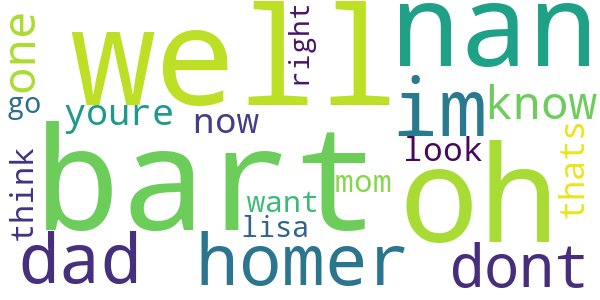

In [39]:
cloud_w = WordCloud(background_color = "white", 
                  max_words = 20, 
                  contour_width = 5, 
                  width = 600, height = 300, 
                  random_state = 5)
cloud_w.generate(w_long)
cloud_w.to_image()

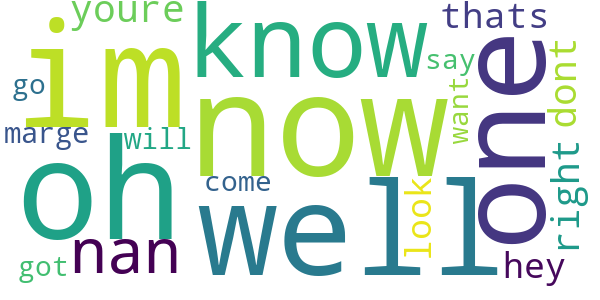

In [40]:
# Define a word cloud variable
cloud_m = WordCloud(background_color = "white", 
                  max_words = 20, 
                  contour_width = 5, 
                  width = 600, height = 300, 
                  random_state = 5)

# Process the word cloud
cloud_m.generate(m_long)

# Visualize!
cloud_m.to_image()

## Unigram Interpretation ##

<b>1. Bart</b> 

Some words that I see standout between the two are what names are spoken. In the women's wordcloud, the term "bart" is used very frequently. From knowing the show, Bart Simpsons is one of the main characters-- the trouble-making son of the Simpsons family. The spaces that Bart occupies as a child are mostly home and school! Moreover, most of Barts friends are boys-- notable ones being Milhouse, Martin, and Nelson. Thus, a large portion of speaking lines for women must be taken up by Barts maternal figures: including Marge Simpsons (Bart's Mom), Edna Krabappel (Bart's Teacher), and Lisa Simpson (Bart's sister). 

We can check this by looking at our datatable.

In [70]:
w_table[['normalized_name', 'line']].groupby('normalized_name').count().sort_values(by='line', ascending= False)

,line
normalized_name,
marge simpson,13193
lisa simpson,10769
edna krabappel-flanders,725
selma bouvier,566
patty bouvier,463
...,...
barbara,20
ms melon,18
evelyn,17


Here we see that Marge and Lisa Simpson do make up a huge majority of the speaking roles. Moreover, the third most prominent women in the show is Edna Krabappel, Bart's teacher-- which we deduced from our unigram model. 

<b>2. Dad</b> 

Similarly, a common term is "dad". Because the Simpsons are the show's main family, it does not dig deeper into many other families' dynamics. Moreover, not many of the family's who get screen time have daughters. With that in mind, Lisa Simpson take up a large portion of womens speaking roles.

We can see this is true by looking at the table above, where Lisa is the second most prominent female character.

<b>3. Oh well, vs. Oh dont!</b> 

Looking closer to the men's wordcloud, we don't see as many names. We do see the term 'marge'; however, there is no general context on how this term could've been used. We see the terms "oh" and "well" appear pretty large in our wordcloud. In comparison to the women's wordcloud which includes a large use of the terms "oh" and "dont".

To get a better angle of the part that term frequency plays, we will visualize a bar plot of each unigram:

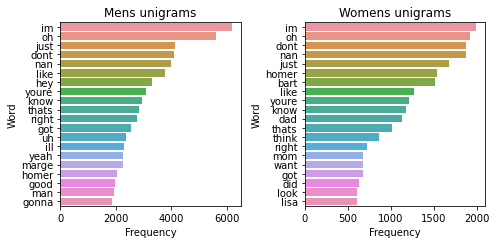

In [43]:
# Visualize word frequencies in a horizontal bar plot

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)
sns.barplot(x = "Frequency",
            y = "Word",
            data = w_df,
            orient = "h",
           ax = axes[1]).set_title('Womens unigrams')
sns.barplot(x = "Frequency",
            y = "Word",
            data = m_df,
            orient = "h",
           ax = axes[0]).set_title('Mens unigrams')
plt.show();

Interestingly enough, we don't find the same results in looking at the barplot. More specifically, the term "well" isn't as present in the mens graph and the term "dont" is almost equally present in both. This could be because we used the long strings for the wordclouds, and the dataframes for this plot. 

However, we do still see a high presence of the terms 'bart' and 'dad' in both graphs. Moreover, the more frequent terms on the mens side-- like "oh", "uh", and "gonna"-- still give off more of a carefree attitude compared to the womens side-- like "know", "think", "want", "did". Thus, this graph is still relatively consistent with our earlier findings. 

Let us now perform the same analysis looking at a bigram model!

In [45]:
# Initialize a bigram model
bigram_vectorizer = CountVectorizer(ngram_range = (2, 2),
                                    stop_words = "english",
                                    token_pattern = r'\b\w+\b', 
                                    min_df = 1)

bigram_vectorizer

CountVectorizer(ngram_range=(2, 2), stop_words='english',
                token_pattern='\\b\\w+\\b')

In [46]:
# Analyze long_string in the bigram bag of words

analyze_w_bi = bigram_vectorizer.build_analyzer()
analyze_m_bi = bigram_vectorizer.build_analyzer()

vocab_w_bi = analyze_w_bi(w_long)
vocab_m_bi = analyze_m_bi(m_long)

In [48]:
freq_w_bi = Counter(vocab_w_bi)
freq_m_bi = Counter(vocab_m_bi)

In [49]:
w_df_bi = pd.DataFrame(freq_w_bi.most_common(20), columns = ["Word", "Frequency"]).reset_index()
m_df_bi = pd.DataFrame(freq_m_bi.most_common(20), columns = ["Word", "Frequency"]).reset_index()

merged_df_bi = m_df_bi.merge(w_df_bi, left_on= 'index', right_on= 'index').drop(columns= 'index').rename(columns={'Word_x': 'Mens', 
                                                                                                         'Frequency_x': 'Freq_m',
                                                                                                        'Word_y': 'Womens',
                                                                                                        'Frequency_y': 'Freq_w'})
merged_df_bi

,Mens,Freq_m,Womens,Freq_w
0,im gonna,627,dont know,266
1,nan nan,555,nan nan,221
2,dont know,480,im sorry,197
3,ive got,418,dont want,162
4,oh yeah,391,im gonna,137
5,dont worry,365,im sure,130
6,im sorry,360,dont think,123
7,woo hoo,338,mr burns,120
8,mr burns,329,oh god,119
9,oh god,315,im going,114


Adding an extra word made a really adds more context to these phrases! Let's skip the wordcloud and go straight to the bar chart for this one:

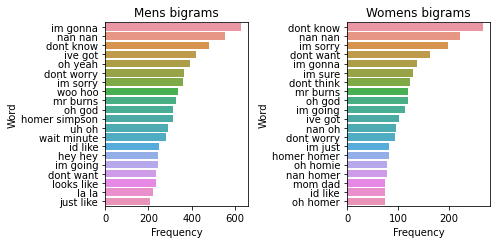

In [51]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)
sns.barplot(x = "Frequency",
            y = "Word",
            data = w_df_bi,
            orient = "h",
           ax = axes[1]).set_title('Womens bigrams')
sns.barplot(x = "Frequency",
            y = "Word",
            data = m_df_bi,
            orient = "h",
           ax = axes[0]).set_title('Mens bigrams')
plt.show();

### Bigram Interpretation ###

In looking at the bigram bar charts, both charts share many phrases. Of the phrases they don't share, there isn't much information that they give which could help characterize the group better. Examples of these phrases include "woo hoo", "wait minute",  "looks like", and "la la". The mens bigram chart does use the phrase "uh oh", which could've implied that they often cause problems. However, this term is not shown to have much frequency. If it were the case that the burden of solving these problems were placed on the women in the show, we would see a corresponding term in the womens bigram chart, yet, we don't see it. 

However, thanks to our bigram model, we see that there exists no "oh dont" nor an "oh well". With this in mind, our previous finding is further clarified by the bigram model! In this way, the bigram model may not have given us more descriptive information than the unigram analysis; however, the bigram analysis was still able increase our analytical accuracy.

### Takeaways ###

From this analysis, we were able to deduce that:

<b>1.</b> The cast of women is mostly comprised of maternal figures to Bart Simpson, the son. These figures include Bart's mom, Bart's sister, and Bart's teacher.

<b>2.</b> Lisa Simpson comprises a large portion of womens speaking roles.

# Topic Model #

Lastly, we will implement a topic model to better characterize the dialogue of each group. A topic model is useful in this scenario because it will offer insight into the main themes the dialogue follows. Thus, unlike the n-gram analysis which gives terms out of context, the topic model offers us groupings of terms to show persistent context. For more information on topic models, <a href='https://medium.com/analytics-vidhya/topic-modelling-techniques-37826fbab549'>check out this article</a> which breaks it down!

On to the topic model. For this project, we are choosing to find 5 topics:

In [71]:
 n_topics = 5

Next, we will split our strings into its individual words-- what we call "tokens".

In [77]:
# Here, we are splitting our
m_tokens = m_long.split()
w_tokens = w_long.split()

Then, we will initialize a vectorizer in the same way that we initialized our CountVectorizer() above. Here, we are allowing for max 500 different features to be used create a model which groups terms more accurately. Moreover, we are removing the most common "english stopwords"-- which are words like "the", "as", etc. which don't provide any real information about the character. 

In [76]:
tfidf_vectorizer_w = TfidfVectorizer(max_df = 0.90,
                                   max_features = 500,
                                   stop_words = "english")

tfidf_vectorizer_m = TfidfVectorizer(max_df = 0.90,
                                   max_features = 500,
                                   stop_words = "english")

# Fit
tfidf_w = tfidf_vectorizer_w.fit_transform(w_tokens)
tfidf_m = tfidf_vectorizer_m.fit_transform(m_tokens)

Lastly, we instantiate our LDA model, which creates an empty instance of our model. This LDA model will then be fit on our data to create the topic model:

In [81]:
# Instantiate our LDA model (this might take a minute or two)

#lda_w = LatentDirichletAllocation(n_components = n_topics, 
#                                max_iter = 20, 
#                                random_state = 42)
# lda_m = LatentDirichletAllocation(n_components = n_topics, 
#                                max_iter = 20, 
#                                random_state = 42)

#lda_w = lda_w.fit(tfidf_w)
#lda_m = lda_m.fit(tfidf_m)

In [82]:
#with open ('lda_w.pk', "wb") as f:
#    pickle.dump(lda_w, f)
    
#with open ('lda_m.pk', "wb") as f:
#    pickle.dump(lda_m, f)

Fitting the LDA models take a long time because the dataset is so large, so instead the LDA models were made and downloaded ahead of time. The models were saved using the pickle library which allowed us to save them as a .pk file. To load them, we just use the pickle library again:

In [84]:
with open('LDA_models/lda_m.pk', 'rb') as f:
    lda_m = pickle.load(f)
with open('LDA_models/lda_w.pk', 'rb') as f:
    lda_w = pickle.load(f)   

### Top Words ###

After creating the model, let us look at the top words of every topic to get an idea of what each represents:

In [86]:
# This function prints out the top words of each topic in our model
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx+1))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [88]:
tf_feature_names_w = tfidf_vectorizer_w.get_feature_names()
print_top_words(lda_w, tf_feature_names_w, 20)


Topic #1:
youre, want, did, look, okay, make, love, theres, kids, say, yes, home, school, help, great, honey, weve, boy, remember, talk

Topic #2:
oh, like, know, little, really, time, ive, gonna, maybe, simpson, mean, better, wait, god, isnt, youll, baby, night, things, bad

Topic #3:
im, think, right, mom, lisa, going, ill, hes, come, sure, hey, didnt, yeah, doing, let, father, marge, said, big, wont

Topic #4:
dont, homer, bart, good, sorry, people, need, whats, tell, day, youve, theyre, new, house, maggie, thought, nice, lot, shes, ooh

Topic #5:
nan, just, dad, thats, got, homie, stop, mr, way, man, thing, lets, thank, uh, guess, family, feel, id, doesnt, believe


In [89]:
tf_feature_names_m = tfidf_vectorizer_m.get_feature_names()
print_top_words(lda_m, tf_feature_names_m, 20)


Topic #1:
oh, dont, like, youre, ill, uh, good, man, little, come, say, simpson, make, dad, lisa, let, life, help, mean, place

Topic #2:
know, marge, gonna, want, think, boy, day, sorry, old, god, son, work, guys, money, mom, guy, school, youll, thanks, away

Topic #3:
im, just, nan, thats, got, yeah, homer, look, okay, ive, did, hes, really, theres, thing, sir, sure, kids, new, ya

Topic #4:
right, time, yes, way, lets, love, going, whats, tell, mr, great, didnt, id, big, home, theyre, said, stop, youve, hell

Topic #5:
hey, bart, need, people, wait, better, huh, gotta, thank, maybe, springfield, thought, family, hello, long, aw, whoa, ooh, isnt, em


### Visualization ###

Now, we will visualize the topic models using the pyLDAvis library:

In [91]:
panel_w = pyLDAvis.sklearn.prepare(lda_model = lda_w, 
                                 dtm = tfidf_w, 
                                 vectorizer = tfidf_vectorizer_w, 
                                 mds = "tsne")
pyLDAvis.display(panel_w)

#### Interpretation ####

As we can see, we have five very separate topics. In the first topic, we see terms like "dad"; "homie",which is Marge's nickname for Homer; "family"; and "mr". With this in mind, I would think that a main theme of the womens dialogue is "family". Using the same intuition for the other topics, it would seem that:

1. Family

2. Small talk (?)

3. Being responsible

4. Mother-daughter/ Family bonding

5. Adult talk (adult love, adult responsibilities, etc.)

Next, let's look at the Men's topic model:

In [92]:
panel_m = pyLDAvis.sklearn.prepare(lda_model = lda_m, 
                                 dtm = tfidf_m, 
                                 vectorizer = tfidf_vectorizer_m, 
                                 mds = "tsne")
pyLDAvis.display(panel_m)

#### Interpretation ####

Topics: 

1. Conversations between Homer and his friends

2. Wholesome conversations

3. Disappointment/ regret

4. Unsure (??)

5. Conversations between Bart and his friends

Though helpful visually, the topics of both models are a bit hard to discern. The topics with the questions marks are counted as still relatively uncertain; however, using the rough categories pieced together, we do see a dynamic between characters emerge. The womens topic model shows that Lisa and Marge have a strong relationship which is elaborated on in the show. Conversely, Bart and Homer both have much more time with their friends than with each other.

Moreover, the womens topic model includes topics like responsibility-- named by the terms 'homer', 'bart', 'good', 'house', and 'maggie'; which I assume exemplifies Marge's responsibility as a mom. This is quite the opposite to mens' topic of disappointment/ regret-- characterized by 'know', 'marge', 'want', 'think', 'sorry'.

# Conclusions #

In conclusion, American tv show, *The Simpsons*, is shown to follow the legacy of commercial gender representation.

### Findings ###

1. As we saw from the line plots, the distribution of men and women characters on the show has been consistently unequal. By the graph, the amount of women speaking roles has increased by less than < 10% in it's 31 seasons.

2. As we can see from the unigram and bigram analysis, Marge and Lisa make up a huge part of womens' speaking roles. Following them is Edna Krabappel-- all three characters being maternal figures to Bart Simpson.

3. Women are written as supportive in the show while men are allowed to experience more sadness. 

### Interpretations ###

With this in mind, having Marge and Lisa take up such a large amount of the speaking roles means that there is even less variety for women characters as previously would've been assumed by the line plot. This means that the small < 30% of the space that women take up is made mostly of two of the main characters. 

Moreover, the top 3 characters all play maternal figures to Bart Simpson-- by teaching him, mothering him, or by nagging him. With this in mind, this point could link to the third point: showing that women are mostly written to support the men characters. 

### Feminist Critique ###

Following the work of Gail T. Houston (1994), this project specifically looks at images of women and the ways in which the tv show engages with gender stereotypes. From our analysis, it seems that *The Simpsons* adopts many stereotypical ideas of the role women can play in stories by giving them little speaking roles and directing their function towards the men characters.

Furthermore, an idea championed by Second-wave feminists: "the personal is political." In other words, this means that the quality individual's personal life is just as much a responsibility of the greater public as a person's public life. This meant that the quality of a home-- the responsibility of which imposed on many women-- is not the responsibility of the family. Instead, the family's dynamic, financial situation, emotional situation, etc. are all products of public life and are a public responsibility. 

Connecting this back to *The Simpsons*, the popular tv show is set around a dysfunctional, nuclear family. Despite the many unrealistic scenarios the Simpsons may face, the way that they treat each other sets a precedent for other family dynamics. Thus, as the personal is political, the lack of proper inclusion and representation of women in the show may perpetuate harmful gender stereotypes in the home which echo out into greater society.

## Further Research ##

As mentioned in this introduction, this project is constricted to a binarical lens of gender in response to the state of the data. Yet, some characters were tagged without a gender label, and we will look at them now:

In [98]:
print('There are ' + str(len(s_char[s_char.isna().any(axis=1)])) + ' characters without a gender label.')
s_char[s_char.isna().any(axis=1)][20:30]

There are 6399 characters without a gender label.


,id,name,normalized_name,gender
20,49,Calvin,calvin,NaN
21,50,"Martin Prince, Sr.",martin prince sr,NaN
22,51,Richard,richard,NaN
23,53,Wendell Borton,wendell borton,NaN
24,57,Smilin' Joe Fission,smilin joe fission,NaN
25,58,Rod #1,rod 1,NaN
26,59,Rod #2,rod 2,NaN
27,60,RODS,rods,NaN
28,61,Workman #1,workman 1,NaN
29,62,Foreman,foreman,NaN


As we can see from the code above, there are 6399 characters that are tagged without a gender label. Looking at the table, we see that some of the characters are given a gender in the show. For example, Calvin and Martin Prince, Sr. are both given male genders in the show. In the case of our dataset, these may just be overlooked mistakes. However, some characters' genders aren't named in the show, like: Wendell Borton, Workman #1, or Foreman. For these characters, a decision must be made about how to handle the ambiguity in order to proceed with analysis. Yet, some characters are not even human-- like Smilin' Joe Fission, who is a mascot. Parsing through each row was out of the scope of this project as I did not have the information to make decisions on ambiguity nor the tools to achieve this goal in a timely manner.

Further research could benefit in looking into the non-labeled characters to separate those that may be determined and those that are too ambiguous or not human. It would be really interesting to include other genders aside from men and women in this analysis, especially for such a popular tv show. 

## Thank you for viewing my project, I hope you enjoyed it! ##

<img src='images/ty.gif'>
<center> credit: <a href='https://giphy.com/gifs/season-2-the-simpsons-2x3-xT5LMwRuJUt3d8Hk3K'>giphy</a></center>